# Face recognition
Uses a combination of dlib's HoG facial detection and the VGGFace2 model to get embeddings of a face.

### Imports

In [1]:
from keras_vggface.vggface import VGGFace
from keras.utils import load_img, img_to_array
from keras.preprocessing import image
from keras_vggface import utils
from scipy.spatial.distance import cosine, euclidean
import matplotlib.pyplot as plt
import numpy as np
import cv2
import dlib
import os

### Using dlib's HoG Face Detection

In [2]:
hog_face_detector = dlib.get_frontal_face_detector()

#### Function to process an image for the keras model:

In [33]:
def prepare_image(image):
    # convert image to array
    indiv_face = img_to_array(image)

    # reshape array for keras input
    x = np.expand_dims(indiv_face, axis=0)

    # apply any necessary pre-processing to the array
    indiv_face = utils.preprocess_input(x, version=2)

    return indiv_face

#### Function to return the cropped image of faces in an image

For a given image, detects the faces using `dlib.get_frontal_face_detector()`. For each face, the image is cropped and appeneded to an array of faces.

In [4]:
def hogDetectFaces(image, hog_face_detector, display=False, target_size=(224, 224)):

    list_faces = [] # array of all faces in image, cropped
    
    # convert image to RGB format
    imgrgb = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    results = hog_face_detector(imgrgb)

    # loop through all faces in the image
    for i, face in enumerate(results):
        output_image = image.copy()

        # get coordinates of box around the face
        x1 = face.left()
        y1 = face.top()
        x2 = face.right()
        y2 = face.bottom()
            
        # crop image to face
        indiv_face = output_image[y1:y2, x1:x2]

        # resize the image for the model 
        indiv_face = cv2.resize(indiv_face, target_size)

        # shows the cropped image face
        if display:
            # cv2.rectangle(output_image, (x1, y1), (x2, y2), (255, 0, 0), 2)  
            output_image_copy = indiv_face.copy()
            plt.figure(figsize=[10,10])
            plt.subplot(121);plt.imshow(output_image_copy[:,:,::-1]);plt.title(f"Face number {i + 1}");plt.axis('off');
       

        # add loaded face to list of faces
        indiv_face = prepare_image(indiv_face)
        list_faces.append(indiv_face)

    return list_faces

### Using the VGGFace2 ResNet-50 model and removing the final layer 

In [5]:
model = VGGFace(model="resnet50", include_top=False, input_shape=(224, 224, 3), pooling='avg')

### Creating the known Face
This is the face that all new faces will be compared to

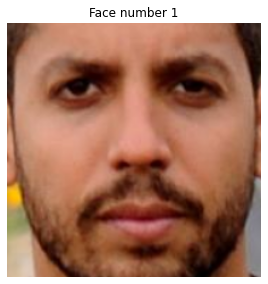

In [6]:
known_face = hogDetectFaces(cv2.imread("./train/D_Blaine.jpg"), hog_face_detector, True)

### Get embedding 
Passing through the image into the ResNet model, it outputs the embedding

In [7]:
known_face_embedding = model.predict(known_face)

1/1 [==============================] - 1s 902ms/step


In [11]:
known_face_embedding

array([[0.       , 4.3707266, 5.1768875, ..., 0.6922699, 1.0115521,
        0.1455126]], dtype=float32)

#### Function to compare a new embedding to the known

In [31]:
def compare_person(new_embedding, new_name, threshold=0.47):
    score = cosine(known_face_embedding[0], new_embedding[0])
    
    if score <= threshold:
        print(f"{new_name} does contain an image of David Blaine, with a score of {score}")
    else:
        print(f"{new_name} does NOT contain an image of David Blaine, with a score of {score}")

### Testing with other faces
Repeating the above steps with all images in the `./test` folder

Loading the image: ../demo/faces/0.jpg
1/1 [==============================] - 0s 86ms/step
Loading the image: ../demo/faces/1.jpg
1/1 [==============================] - 0s 82ms/step
Loading the image: ../demo/faces/2.jpg
1/1 [==============================] - 0s 96ms/step
Loading the image: ../demo/faces/3.jpg
1/1 [==============================] - 0s 89ms/step
Loading the image: ../demo/faces/4.jpg
1/1 [==============================] - 0s 86ms/step
Loading the image: ../demo/faces/5.jpg
1/1 [==============================] - 0s 94ms/step
Loading the image: ../demo/faces/6.jpg
1/1 [==============================] - 0s 87ms/step
Loading the image: ../demo/faces/7.jpg
1/1 [==============================] - 0s 119ms/step
Loading the image: ../demo/faces/8.jpg
1/1 [==============================] - 0s 85ms/step
Loading the image: ../demo/faces/9.jpg
1/1 [==============================] - 0s 86ms/step


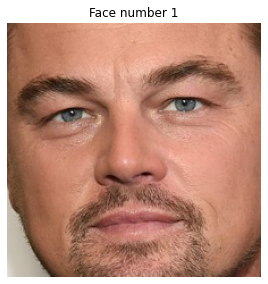

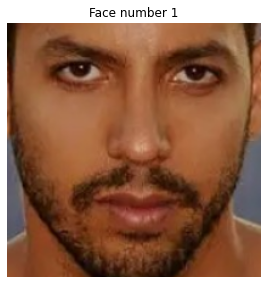

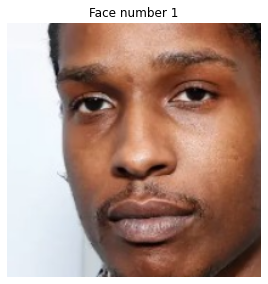

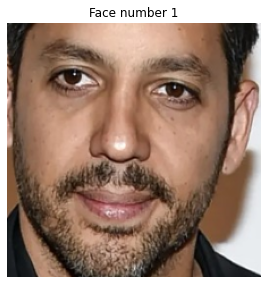

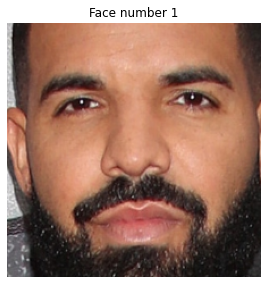

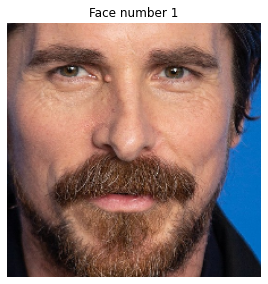

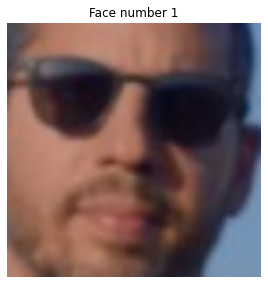

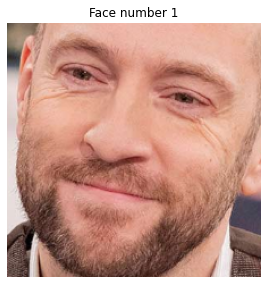

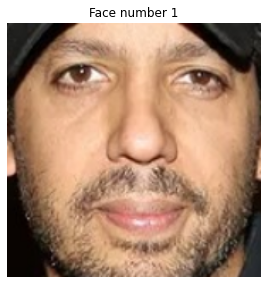

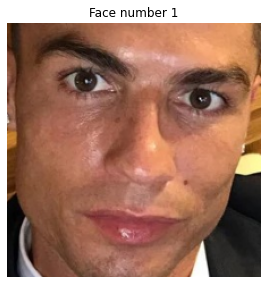

In [30]:
# loop through directory, storing each image in an array
all_embeddings = []
imgs_path = "../demo/faces/"
for subdir, dirs, files in os.walk(imgs_path):
    for file in files:
        new_file = imgs_path + file
        print(f"Loading the image: {new_file}")
        # crop image
        try:
            known_face = hogDetectFaces(cv2.imread(new_file), hog_face_detector, True)
            temp_face_embedding = model.predict(known_face)
            all_embeddings.append(temp_face_embedding)
        except:
            print(f"Error loading the file: {new_file}")
            continue

    

#### To compare embeddings

In [35]:
for i, pred in enumerate(all_embeddings):
    compare_person(pred, str(i)+".jpg")

0.jpg does NOT contain an image of David Blaine, with a score of 0.7477829456329346
1.jpg does contain an image of David Blaine, with a score of 0.16664564609527588
2.jpg does NOT contain an image of David Blaine, with a score of 0.6714400351047516
3.jpg does contain an image of David Blaine, with a score of 0.23558765649795532
4.jpg does NOT contain an image of David Blaine, with a score of 0.5872397422790527
5.jpg does NOT contain an image of David Blaine, with a score of 0.6979840397834778
6.jpg does contain an image of David Blaine, with a score of 0.4559456706047058
7.jpg does NOT contain an image of David Blaine, with a score of 0.7185100018978119
8.jpg does contain an image of David Blaine, with a score of 0.26025354862213135
9.jpg does NOT contain an image of David Blaine, with a score of 0.6094020009040833
